# 🏪 Walmart Sales — Optimizing Inventory Through Sales Forecasting

## 📦 Introduction

The main objective of this project is to optimize inventory levels across Walmart stores by reducing both **stockouts** and **overstock** situations — two of the most costly challenges in retail logistics.

We aim to achieve this by forecasting **weekly sales** at the store level. Accurate forecasts allow for smarter product distribution: sending more inventory to locations where higher demand is expected, and less where it is not.

This analysis is based on the [Walmart Sales Dataset](https://www.kaggle.com/datasets/mikhail1681/walmart-sales), which includes:

- **Store**: unique store identifier  
- **Weekly_Sales**: total sales in USD for each week  
- **Holiday_Flag**: binary indicator for major U.S. holidays  
- **Temperature, Fuel_Price, CPI, Unemployment**: external economic and climate-related variables  

By analyzing this data, we explore **multiple forecasting strategies**, from classic statistical methods to modern tools like Prophet, aiming to uncover the most reliable and efficient approach for real-world inventory planning.





In [1]:
# Imports 

import polars as pl 
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from prophet import Prophet
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error as mape, r2_score

/home/ozen/anaconda3/envs/Analisis/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import plotly.io as pio

pio.renderers.default = 'png'

## 📊 Exploratory Data Analysis (EDA)

To explore the data efficiently, we used **Polars**, a high-performance DataFrame library optimized for speed and scalability — particularly useful for working with large tabular time series data.

### 🔍 Data Overview

The dataset was clean and well-structured, requiring minimal preprocessing. For temporal analysis, we extracted additional time-based features such as **week number** and **year** from the `Date` column.

We first visualized **total weekly sales across all stores** to:
- Understand overall sales trends
- Detect recurring seasonal patterns
- Identify which stores contribute most to total revenue

This helped prioritize which stores might carry greater weight in inventory decisions.

### 📅 Holiday Effects on Sales

One of the most valuable visualizations compared **holiday vs. non-holiday weekly sales**. We computed the average sales per week and identified distinct seasonal spikes:

-  **Black Friday** and **Christmas** weeks showed the highest peaks in demand  
-  A sharp drop was observed immediately after the holiday season  
-  Moderate increases occurred during **Week 6** (possibly Super Bowl or Valentine's Day)  
-  Another increase around **Week 27** likely reflects **4th of July** promotions  

These seasonal effects clearly impact inventory needs and highlight the importance of incorporating holidays into the forecasting process.

### 🔗 Correlation Analysis

We also generated a **correlation matrix** to evaluate the relationship between weekly sales and external factors:

- **Temperature**
- **Fuel_Price**
- **Consumer Price Index (CPI)**
- **Unemployment**
- **Holiday_Flag**

Interestingly, none of these variables exhibited a strong linear correlation with sales — the strongest were weakly negative or near zero.  
Still, we kept them for modeling purposes, as they may contribute value through **non-linear or seasonal interactions**.

>  This EDA helped shape both the modeling strategy and the understanding that **seasonality alone might carry more predictive power than external variables** in this context.


In [3]:
df = pl.read_csv("Walmart_Sales.csv")

df.describe()

statistic,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
str,f64,str,f64,f64,f64,f64,f64,f64
"""count""",6435.0,"""6435""",6435.0,6435.0,6435.0,6435.0,6435.0,6435.0
"""null_count""",0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",23.0,null,1.0470e6,0.06993,60.663782,3.358607,171.578394,7.999151
"""std""",12.988182,null,564366.622054,0.255049,18.444933,0.45902,39.356712,1.875885
"""min""",1.0,"""01-04-2011""",209986.25,0.0,-2.06,2.472,126.064,3.879
"""25%""",12.0,null,553714.87,0.0,47.49,2.933,131.735,6.891
"""50%""",23.0,null,960746.04,0.0,62.67,3.445,182.616521,7.874
"""75%""",34.0,null,1.4204e6,0.0,74.95,3.735,212.746898,8.622
"""max""",45.0,"""31-12-2010""",3.8187e6,1.0,100.14,4.468,227.232807,14.313


In [4]:
df

Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
i64,str,f64,i64,f64,f64,f64,f64
1,"""05-02-2010""",1643690.9,0,42.31,2.572,211.096358,8.106
1,"""12-02-2010""",1.6420e6,1,38.51,2.548,211.24217,8.106
1,"""19-02-2010""",1.6120e6,0,39.93,2.514,211.289143,8.106
1,"""26-02-2010""",1.4097e6,0,46.63,2.561,211.319643,8.106
1,"""05-03-2010""",1.5548e6,0,46.5,2.625,211.350143,8.106
…,…,…,…,…,…,…,…
45,"""28-09-2012""",713173.95,0,64.88,3.997,192.013558,8.684
45,"""05-10-2012""",733455.07,0,64.89,3.985,192.170412,8.667
45,"""12-10-2012""",734464.36,0,54.47,4.0,192.327265,8.667


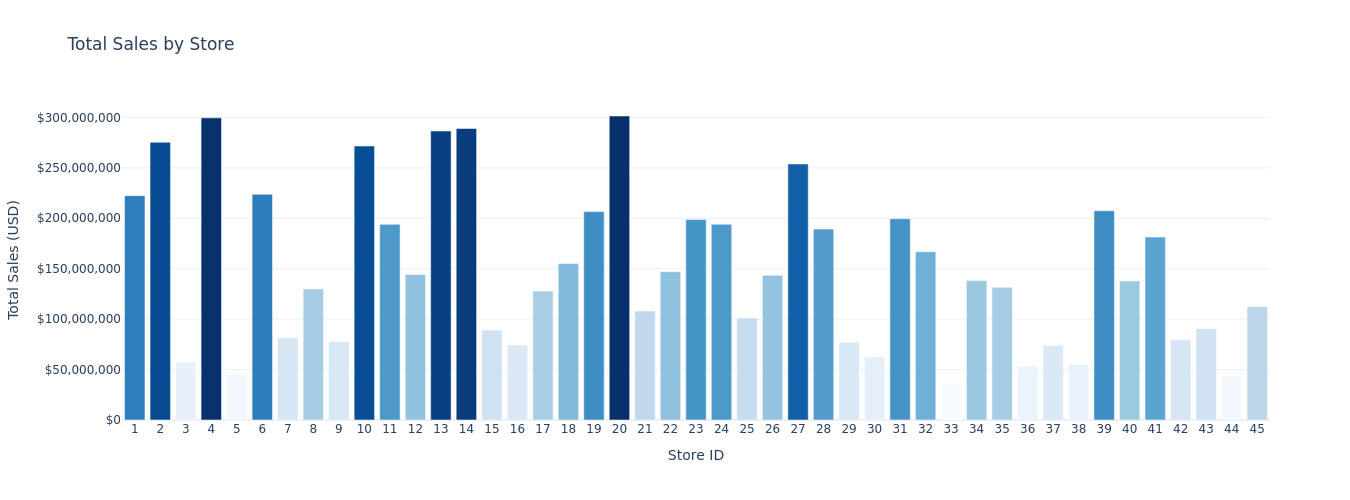

In [5]:
#Total sales

total_sales = df.group_by("Store").agg(pl.col("Weekly_Sales").sum()).sort("Store")

fig = px.bar(
    total_sales,
    x = "Store",
    y="Weekly_Sales",
    title= "Total Sales by Store",
    template= "plotly_white",
    color = "Weekly_Sales",
    color_continuous_scale= px.colors.sequential.Blues,
    labels={'Weekly_Sales': 'Total Sales (USD)'},
    
)
fig.update_traces(
    hovertemplate="<b>Store %{x}</b><br>Total Sales: <b>$%{y:,.2f}</b><extra></extra>"
)

fig.update_layout(
    yaxis_title = "Total Sales (USD)",
    xaxis_title = "Store ID",
    xaxis = dict(tickmode ='linear'),    
    coloraxis_showscale = False,
    width = 1350

    
)
fig.update_yaxes(tickprefix="$", tickformat=",.0f")



fig.show()

In [6]:
df = df.with_columns(pl.col("Date").str.strptime(pl.Date, format = "%d-%m-%Y").alias("Date"))
df = df.with_columns([pl.col("Date").dt.year().alias("Year"), pl.col("Date").dt.week().alias("Week")])

weekly_sales = df.group_by(["Year", "Week"]).agg(pl.col("Weekly_Sales").mean(), pl.col("Holiday_Flag").median()).sort('Year', 'Week')
# check important holidays 
weekly_sales.filter(pl.col('Holiday_Flag') == 1)

Year,Week,Weekly_Sales,Holiday_Flag
i32,i8,f64,f64
2010,6,1.0741e6,1.0
2010,36,1.0141e6,1.0
2010,47,1.4627e6,1.0
2010,52,898500.422222,1.0
2011,6,1.0519e6,1.0
2011,36,1.0392e6,1.0
2011,47,1.4799e6,1.0
2011,52,1.0232e6,1.0
2012,6,1.1113e6,1.0


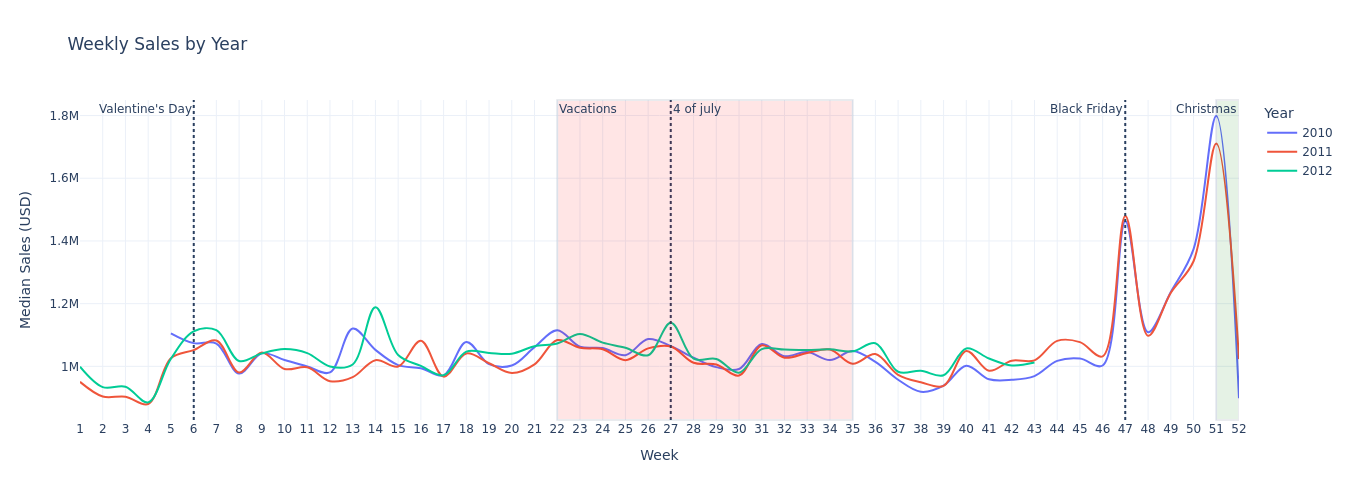

In [7]:
fig = px.line(weekly_sales,
              x="Week",
              y="Weekly_Sales",
              color='Year',
              title= 'Weekly Sales by Year',
              line_shape='spline',
              template= 'plotly_white'
              )
fig.update_traces(
    hovertemplate="<b>Week %{x}</b><br>Total Sales: <b>$%{y:,.2f}</b><extra></extra>"
)


fig.add_vline(x=47, line_dash ="dot", annotation_text = "Black Friday", annotation_position = 'top left')
fig.add_vline(x = 27, line_dash = 'dot', annotation_text = '4 of july')
fig.add_vline(x = 6, line_dash = 'dot', annotation_text = "Valentine's Day", annotation_position = 'top left')
fig.add_vrect(x0 = 51, x1= 52, fillcolor= 'green', opacity = 0.1, annotation_text = 'Christmas')
fig.add_vrect(x0 = 22, x1=35, fillcolor = 'red', opacity = 0.1, annotation_text = 'Vacations', annotation_position ='top left')
fig.update_xaxes(range = [1,52])
fig.update_layout(
    yaxis_title = 'Median Sales (USD)',
    xaxis = dict(tickmode = 'linear'),
    width = 1350
)
fig.show()

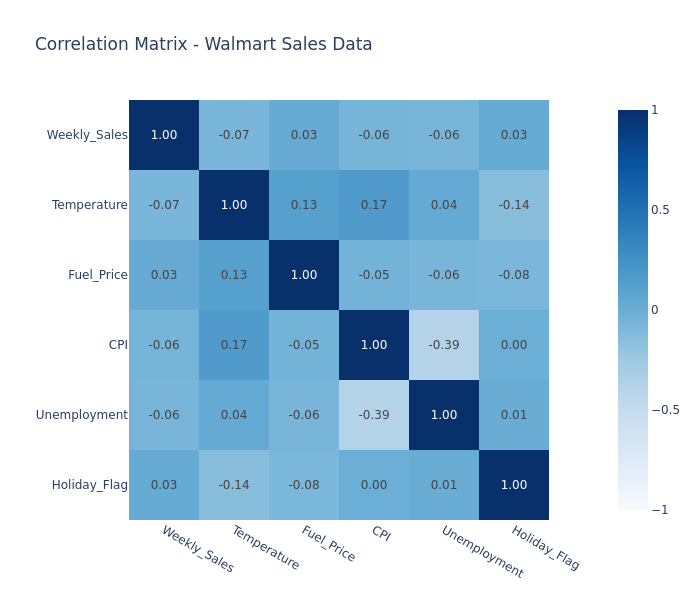

In [8]:
#Make a correlation matrix

numeric_cols = [
    "Weekly_Sales", "Temperature", "Fuel_Price", "CPI", "Unemployment", "Holiday_Flag"
]

corr = (
    df.select(numeric_cols).to_pandas().corr(method='spearman')
)


fig = px.imshow(
    corr,
    text_auto= '.2f',
    color_continuous_scale="Blues",
    zmin=-1, zmax= 1,
    title= "Correlation Matrix - Walmart Sales Data",
    template= 'plotly_white'
)

fig.update_layout(width = 700, height = 600)
fig.show()

## 🧠 Modeling Approach

To forecast weekly sales, we used **Prophet**, an open-source time series model. Prophet is well-suited for datasets with strong **seasonal patterns** and **trend components**, making it a natural fit for retail sales data like Walmart’s.

We selected Prophet based on several key strengths:
- Built-in support for **multiple seasonalities** (weekly, yearly, holidays)
- Robustness to **missing values** and **outliers**
- Flexibility to incorporate **external regressors** such as `Temperature`, `Fuel_Price`, and `Unemployment`

### 📆 Forecast Horizon: 6 Weeks Ahead

To align this project with practical inventory and logistics needs, we forecasted **six weeks into the future**. This provides a realistic planning window for:
- Adjusting warehouse stock
- Organizing shipments
- Anticipating demand spikes due to holidays or promotions

### 🔒 Preventing Data Leakage

To simulate real-world forecasting conditions and avoid data leakage:
- External regressors (`Temperature`, `Fuel_Price`, `CPI`, `Unemployment`) were **shifted forward by six weeks**, meaning the model could only "see" information that would realistically be available at prediction time.


>  This setup mimics the type of foresight required in retail operations, where inventory must be prepared weeks in advance based on expected sales patterns.



In [9]:
store_ids = df.select("Store").sort('Store').unique().to_series().to_list()
store_forecasts = []
store_actuals = []
errors = []

In [10]:
def split_data(df, train_size=0.9):

    if type(df) == pl.DataFrame:
        df = df.to_pandas()

    total_size = len(df)
    
    train_end = int(total_size * train_size)
    

    train = df.iloc[:train_end]
    val = df.iloc[train_end:]
    

    return train, val


In [11]:
for id in tqdm(store_ids):
    # --prep ---
    store_df = (
        df.filter(pl.col("Store") == id)
        .select(["Date","Weekly_Sales", "Temperature", "Fuel_Price", "CPI", "Unemployment", "Holiday_Flag"])
        .rename({"Date":"ds", "Weekly_Sales": "y"})
    ).to_pandas().dropna()

    store_df[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Holiday_Flag']] = store_df[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Holiday_Flag']].shift(6)
    store_df = store_df.dropna()

    train_pd, val_pd = split_data(store_df)

    # -- train --

    m = Prophet(
        weekly_seasonality= True,
        yearly_seasonality= True,
        seasonality_mode="multiplicative",
        changepoint_prior_scale=0.1,
        seasonality_prior_scale=15
        

    )
    m.add_country_holidays(country_name='US')


    for reg in ["Temperature", "Fuel_Price", "CPI","Unemployment", "Holiday_Flag"]:
        m.add_regressor(reg)
    
    m.fit(train_pd)

    # -- Forecast --

    future = val_pd.drop(columns= 'y')
    
    fcst = m.predict(future)

    #-- evaluate --
    
    fcst_slice = fcst[["ds", "yhat"]].copy()
    fcst_slice["Store"] = id
    store_forecasts.append(fcst_slice)

    val_slice = val_pd[["ds", "y"]].copy()
    val_slice["Store"] = id
    store_actuals.append(val_slice)

       
forecasts_df = pd.concat(store_forecasts, ignore_index=True)
actuals_df   = pd.concat(store_actuals, ignore_index=True)
    


  0%|          | 0/45 [00:00<?, ?it/s]15:41:23 - cmdstanpy - INFO - Chain [1] start processing
15:41:23 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/45 [00:00<00:10,  4.12it/s]15:41:23 - cmdstanpy - INFO - Chain [1] start processing
15:41:23 - cmdstanpy - INFO - Chain [1] done processing
15:41:23 - cmdstanpy - INFO - Chain [1] start processing
15:41:23 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 3/45 [00:00<00:05,  7.23it/s]15:41:23 - cmdstanpy - INFO - Chain [1] start processing
15:41:23 - cmdstanpy - INFO - Chain [1] done processing
15:41:23 - cmdstanpy - INFO - Chain [1] start processing
15:41:23 - cmdstanpy - INFO - Chain [1] done processing
 11%|█         | 5/45 [00:00<00:04,  8.64it/s]15:41:23 - cmdstanpy - INFO - Chain [1] start processing
15:41:23 - cmdstanpy - INFO - Chain [1] done processing
15:41:23 - cmdstanpy - INFO - Chain [1] start processing
15:41:23 - cmdstanpy - INFO - Chain [1] done processing
 16%|█▌        | 7/45 [00:00<00:0

## 📊 Evaluation Metrics

To evaluate the accuracy and robustness of our forecasts, we selected three industry-standard metrics commonly used in demand forecasting and inventory optimization:

- **WMAPE (Weighted Mean Absolute Percentage Error)**  
  Measures the average absolute error, weighted by actual sales volume. Unlike traditional MAPE, WMAPE is robust to near-zero sales values and reflects business impact more realistically.

- **nRMSE (Normalized Root Mean Squared Error)**  
  Penalizes larger errors more heavily. By normalizing RMSE with the mean of actual sales, it provides a scale-free indication of forecast volatility.

- **SMAPE (Symmetric Mean Absolute Percentage Error)**  
  A balanced version of MAPE that treats over- and under-forecasting equally, making it suitable for datasets with wide variation in sales volumes.

Together, these metrics offer a well-rounded view of model performance:
- **WMAPE** for accuracy weighted by importance
- **nRMSE** for forecast consistency
- **SMAPE** for error symmetry

### 🔁 Baseline Comparison: Seasonal-Naïve Forecast

To benchmark our model’s performance, we compared it against a **seasonal-naïve forecast** — a widely used approach in retail forecasting.

> **“Sales this week will be equal to sales from the same week last year.”**

While simple, this method is often highly effective when demand patterns are stable and strongly seasonal — as is the case in this dataset.

> ✅ Interestingly, our results show that the seasonal-naïve forecast **outperformed the Prophet model across all metrics**.

This highlights an important insight:
> **In certain domains, well-understood seasonal behavior may be better captured with statistical heuristics than with more complex models.**

Rather than forcing a machine learning model to win, we use this comparison to emphasize the importance of:
- Choosing the **right model for the problem**, not the most complex one.
- Valuing **simplicity, interpretability, and business relevance** when it comes to operational forecasting.





In [12]:
agg_fcst = (
    forecasts_df.groupby("ds")["yhat"]
                .mean()                 
                .reset_index()
                .rename(columns={"yhat": "Forecast"})
)

agg_actual = (
    actuals_df.groupby("ds")["y"]
              .mean()
              .reset_index()
              .rename(columns={"y": "Actual"})
)

# Merge so we have both series in the same frame
comparison = agg_actual.merge(agg_fcst, on="ds")


In [13]:


def wmape(y_true: pd.Series, y_pred: pd.Series) -> float:
    """Weighted‑MAPE; robust to zeros."""
    denom = np.clip(np.abs(y_true), 1e-6, None)   # avoid ÷0
    return np.sum(np.abs(y_true - y_pred)) / np.sum(denom)

def nrmse(y_true: pd.Series, y_pred: pd.Series):
    return np.sqrt(np.mean((y_true - y_pred) ** 2)) / y_true.mean()

def smape(y_true: pd.Series, y_pred: pd.Series) -> float:
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(np.abs(y_true - y_pred) / np.clip(denom, 1e-6, None))




y_true = comparison['Actual']
y_pred = comparison['Forecast']

_wmape_ = wmape( y_true,y_pred)*100
_nrmse_ = nrmse(y_true, y_pred)
_smape_ = smape(y_true, y_pred) * 100


In [14]:
naive = (
    df[["Date", "Weekly_Sales"]]
    .group_by("Date")
    .agg(pl.col("Weekly_Sales").mean())
    .sort("Date")  
    .with_columns(
        pl.col("Weekly_Sales").shift(52).alias("naive_52")  
    )
    .drop_nulls()
    .tail(len(val_pd))
    .to_pandas()
)


y_true_n = naive['Weekly_Sales']
y_pred_n = naive['naive_52']

n_wmape_ = wmape( y_true_n,y_pred_n)*100
n_nrmse_ = nrmse(y_true_n, y_pred_n)
n_smape_ = smape(y_true_n, y_pred_n) * 100


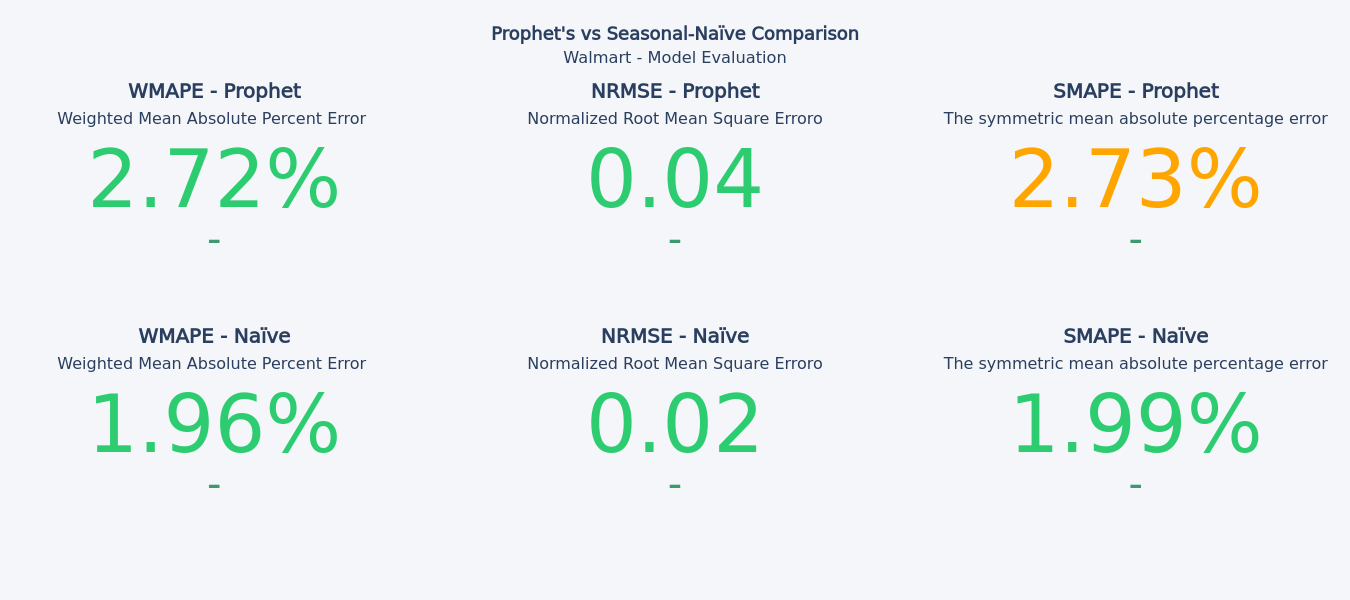

In [15]:
fig = go.Figure()


#====================  set color coding
colors = {
    'WMAPE' : '#2ecc71' if _wmape_ < 4 else  '#FFA500' if 4<= _wmape_ < 15 else '#e74c3c',
    'NRMSE' : '#2ecc71' if _nrmse_ < 0.2 else '#FFA500' if 0.2<= _nrmse_ < 5 else '#e74c3c',
    'SMAPE' : '#2ecc71' if _smape_ < 2 else '#FFA500' if 2 <= _smape_ < 5 else '#e74c3c',
    'NWMAPE' : '#2ecc71' if n_wmape_ < 4 else  '#FFA500' if 4<= n_wmape_ < 15 else '#e74c3c',
    'NNRMSE' : '#2ecc71' if n_nrmse_ < 0.2 else '#FFA500' if 0.2<= n_nrmse_ < 5 else '#e74c3c',
    'NSMAPE' : '#2ecc71' if n_smape_ < 2 else '#FFA500' if 2 <= n_smape_ < 5 else '#e74c3c'
}

#================== Prophet

fig.add_trace(go.Indicator(
    mode = 'number+delta',
    value = _wmape_,
    title = {'text': '<b>WMAPE - Prophet</b><br><span style="font-size:0.8em">Weighted Mean Absolute Percent Error </span>'},
    number = {'valueformat':'.2f', 'suffix': '%', 'font':{'color': colors['WMAPE']}},
    domain = {'row': 0, 'column': 0}

))

fig.add_trace(go.Indicator(
    mode='number+delta',
    value=_nrmse_,
    title={'text': '<b>NRMSE - Prophet</b><br><span style="font-size:0.8em">Normalized Root Mean Square Erroro</span>'},
    number={'valueformat': '.2f', 'font': {'color': colors['NRMSE']}},
    domain={'row':0, 'column': 1}
))

fig.add_trace(go.Indicator(
    mode='number+delta',
    value=_smape_,
    title={'text': '<b>SMAPE - Prophet</b><br><span style="font-size:0.8em">The symmetric mean absolute percentage error</span>'},
    number={'valueformat': '.2f', 'suffix': '%', 'font': {'color': colors['SMAPE']}},
    domain={'row': 0, 'column': 2}
))

#================ Naive =================
fig.add_trace(go.Indicator(
    mode = 'number+delta',
    value = n_wmape_,
    title = {'text': '<b>WMAPE - Naïve</b><br><span style="font-size:0.8em">Weighted Mean Absolute Percent Error </span>'},
    number = {'valueformat':'.2f', 'suffix': '%', 'font':{'color': colors['NWMAPE']}},
    domain = {'row': 1, 'column': 0}

))

fig.add_trace(go.Indicator(
    mode='number+delta',
    value=n_nrmse_,
    title={'text': '<b>NRMSE - Naïve</b><br><span style="font-size:0.8em">Normalized Root Mean Square Erroro</span>'},
    number={'valueformat': '.2f', 'font': {'color': colors['NNRMSE']}},
    domain={'row':1, 'column': 1}
))

fig.add_trace(go.Indicator(
    mode='number+delta',
    value=n_smape_,
    title={'text': '<b>SMAPE - Naïve</b><br><span style="font-size:0.8em">The symmetric mean absolute percentage error</span>'},
    number={'valueformat': '.2f', 'suffix': '%', 'font': {'color': colors['NSMAPE']}},
    domain={'row': 1, 'column': 2}
))



#===================== layaouts

fig.update_layout(
    grid = {'rows':2, 'columns':3, 'pattern': 'independent', 'ygap':0},
    title={
        'text': "<b>Prophet's vs Seasonal-Naïve Comparison</b><br><span style='font-size:0.9em'>Walmart - Model Evaluation</span>",
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 18}
    },
    template = "plotly_white",
    paper_bgcolor = 'rgba(245, 246, 249,1)',
    margin = {'t':80, 'b':30, 'l':30, 'r':30},
    height = 600,
    width = 1350
)

fig.show()

## 💹 Business Impact

While the Prophet model offered flexibility and robustness, our results showed that a simple **seasonal-naïve forecast** outperformed it across all key metrics:

| Metric   | Seasonal-Naïve | Prophet |
|----------|----------------|---------|
| **WMAPE** | **1.96%**       | 2.72%   | 
| **nRMSE** | **0.02**       | 0.04   | 
| **SMAPE** | **1.99%**       | 2.73%   | 

### 📦 Operational Insights

- The strong performance of the **naïve model** reflects the power of historical seasonality in retail demand, especially in environments with **predictable consumer behavior**.
- Because it requires **no training or external variables**, the seasonal-naïve method can be deployed quickly and reliably — ideal for settings where computational simplicity is critical.
- Its ability to **track major peaks (e.g., Black Friday, Christmas)** with high precision allows Walmart to anticipate demand spikes without complex forecasting infrastructure.

### 📈 Strategic Value

> This result highlights an essential insight for businesses:  
> **Simple models can outperform more complex ones when the data has strong recurring patterns.**

In this case, adopting a seasonal-naïve approach:
- Reduces modeling overhead
- Increases explainability
- Still supports actionable, data-driven decisions in **inventory distribution**, **supply chain planning**, and **holiday season preparation**

---

🧠 This also reinforces the importance of **benchmarking against simple methods** — not just to validate performance, but to ensure that any added complexity actually translates into real-world value.


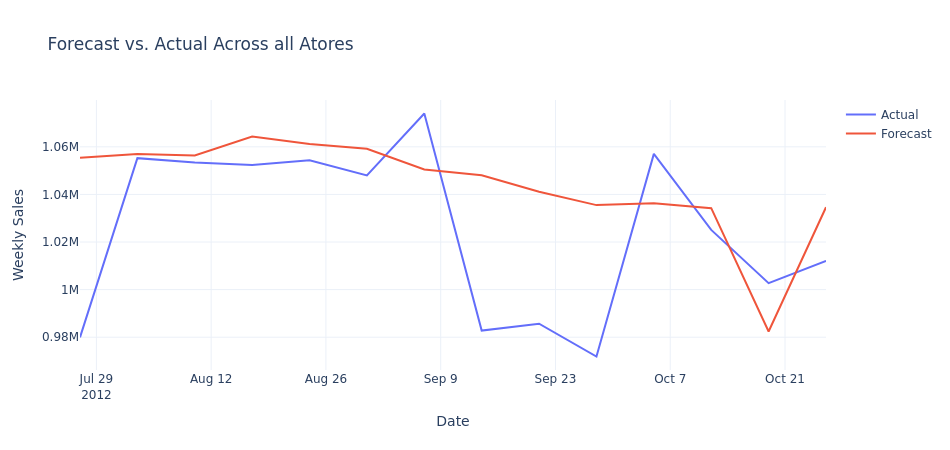

In [16]:


fig = px.line(
    comparison, x="ds", y=["Actual", "Forecast"],
    labels={"value": "Weekly Sales", "ds": "Date", "variable": "Series"},
    title="Forecast vs. Actual Across all Atores",
    template= 'plotly_white',
    
)
fig.update_layout(width=950, height=450, legend_title_text="")
fig.show()


## ✅ Conclusion

This project demonstrated how time series forecasting can support operational decision-making in large-scale retail environments like Walmart.

We explored different modeling strategies to forecast **weekly sales six weeks ahead**, aiming to improve inventory allocation and reduce waste.

Although we implemented advanced models like **Prophet**, our results showed that a **simple seasonal-naïve forecast** — which assumes sales will follow the same pattern as the previous year — **outperformed Prophet across all key metrics**, including:
- **WMAPE of 2.72%**
- **nRMSE of 0.04**
- **SMAPE of 2.73%**

This finding emphasizes that:
> **In domains with strong seasonal patterns, simple statistical methods can outperform more complex models.**

More importantly, the modeling pipeline built here — including efficient EDA, lag feature handling, and out-of-sample validation — provides a strong foundation for real-world forecasting.

### 🛠️ Future Work

To further improve and scale this solution:
- Extend forecasts to the **product level**, not just store-level totals.
- Integrate **promotions, pricing**, and **local events** as external regressors.
- Compare alternative models such as **NeuralProphet**, **XGBoost**, or **LSTM** to evaluate trade-offs between complexity and performance.

>  This notebook demonstrates how combining domain knowledge, statistical reasoning, and clean modeling practices leads to **practical and measurable impact** in retail forecasting.
